# Model training
In this notebook a model is created, trained and evaluated on the test set.
<br>MLFlow is used to track the experiments and push a model to production.

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import mlflow

from countryguess.data import Dataset, TestDataset
from countryguess.model import TripletModel
from countryguess.generate import TripletDataset, ValDataset
from countryguess.training import triplet_mining, eval_fn

## Plotting datasets

### Initialise datasets

In [33]:
shape=(160, 160)
ref_data = Dataset(shape=shape)
train_data = TripletDataset(shape=shape, temp=0.7)
val_data = ValDataset(shape=shape, temp=0.7)
test_data = TestDataset(shape=shape)

### Plotting

#### Training data

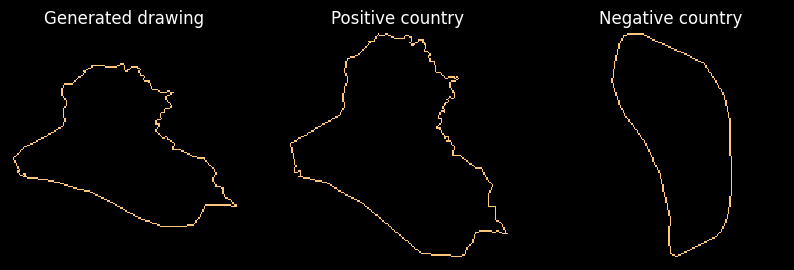

In [98]:
idx = random.randint(0, len(train_data) - 1)
sample = train_data[idx]

#Plotting
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
fig.patch.set_facecolor('black')
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower', cmap='copper')
axs[0].set_title("Generated drawing", color='white') 
axs[1].imshow(sample["pos_img"], interpolation='nearest', origin='lower', cmap='copper')
axs[1].set_title("Positive country", color='white')
axs[2].imshow(sample["neg_img"], interpolation='nearest', origin='lower', cmap='copper')
axs[2].set_title("Negative country", color='white')
for ax in axs: ax.axis('off')
plt.show()

#### Validation set

In [99]:
from countryguess.data import poly_to_img

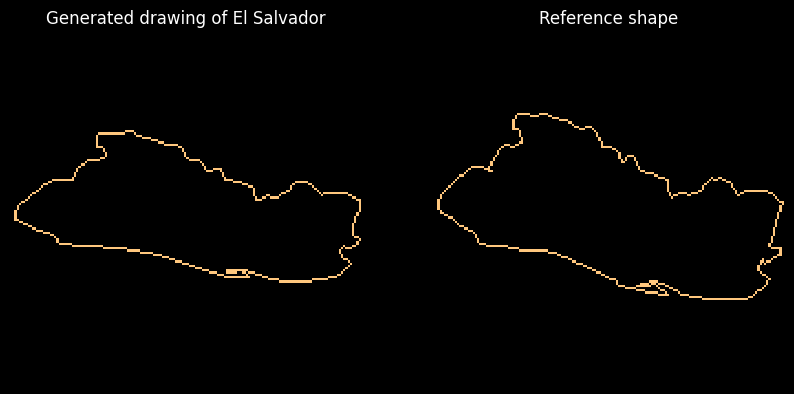

In [100]:
idx = random.randint(0, len(val_data) - 1)
sample = val_data[idx]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.patch.set_facecolor('black')
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower', cmap='copper')
axs[0].set_title(f"Generated drawing of {sample['country_name']}", color='white') 

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(img, interpolation='nearest', origin='lower', cmap='copper')
axs[1].set_title("Reference shape", color='white')
for ax in axs: ax.axis('off')
plt.show()

#### Test set (user drawings)

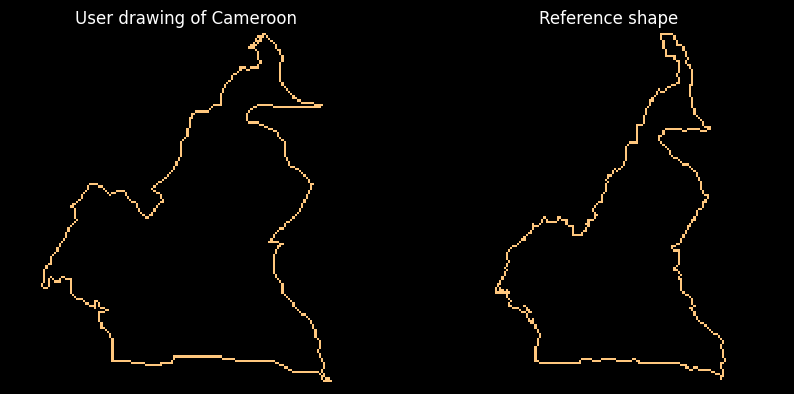

In [101]:
idx = random.randint(0, len(test_data) - 1)
sample = test_data[idx]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.patch.set_facecolor('black')
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower', cmap='copper')
axs[0].set_title(f"User drawing of {sample['country_name']}", color='white')

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(img, interpolation='nearest', origin='lower', cmap='copper')
axs[1].set_title("Reference shape", color='white')
for ax in axs: ax.axis('off')
plt.show()

## Training model

Run the following command to start the MLFlow Tracking UI: `mlflow ui --port 5001`
<br>Access the MLFlow Tracking UI at: http://127.0.0.1:5001

In [21]:
device = torch.device("mps")

In [41]:
mlflow.set_experiment("default")

params = {"channels": 20, #4*random.randint(1, 6),
          "nr_conv_blocks": 4, #random.randint(2, 5),
          "embedding_size": 96, #32*random.randint(2, 7),
          "shape": 64, #32*random.randint(1, 5),
          "learning_rate": 0.008, #random.uniform(0.006, 0.012), 
          "margin": 1, #random.uniform(0.5, 1.5),
          "temperature": 0.73, #random.uniform(0.3, 0.8),
          "nr_epochs": 60} #random.randint(15, 60)}
print(params)

model = TripletModel(**params).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=params['learning_rate'])
triplet_loss = nn.TripletMarginLoss(margin=params['margin'])

{'channels': 20, 'nr_conv_blocks': 4, 'embedding_size': 96, 'shape': 64, 'learning_rate': 0.008, 'margin': 1, 'temperature': 0.73, 'nr_epochs': 60}


In [42]:
#Initialise datasets
ref_data = Dataset(shape=(params["shape"], params["shape"]))
train_data = TripletDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])
val_data = ValDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])

train_dl = DataLoader(train_data, batch_size=24, shuffle=True, num_workers=2)
val_dl = DataLoader(val_data, batch_size=24, num_workers=2)

In [43]:
with mlflow.start_run() as run:
    mlflow.log_params(params)
    
    #Start training
    for epoch in range(params['nr_epochs']):
        losses = []        
        model.train()
        for batch in train_dl:
            optimizer.zero_grad(set_to_none=True)
            anc_emb = model(batch['drawing'][:, None, :, :].type(torch.float32).to(device))
            pos_emb = model(batch['pos_img'][:, None, :, :].type(torch.float32).to(device))
            neg_emb = model(batch['neg_img'][:, None, :, :].type(torch.float32).to(device))
    
            #Mine triplets
            anc_emb, pos_emb, neg_emb = triplet_mining(anc_emb, pos_emb, neg_emb, 
                                                       batch["pos_idx"], batch["neg_idx"])
    
            loss = triplet_loss(anc_emb, pos_emb, neg_emb)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
    
        mlflow.log_metric("loss", np.mean(losses), epoch)
        
        print('Epoch: {}/{}\t loss: {:.3f}'.format(epoch+1, params['nr_epochs'], np.mean(losses)))
    
        if (epoch+1)%5==0:
            ranking = np.array([])
            model.eval()
            model.load_reference(ref_data)
            for batch in val_dl:
                rank = eval_fn(model, batch)
                ranking = np.append(ranking, rank)
    
            mlflow.log_metric("val_avg_rank", np.mean(ranking) + 1, epoch)
            mlflow.log_metric("val_top_10_acc", np.mean(ranking < 10), epoch)
            mlflow.log_metric("val_top_1_acc", np.mean(ranking < 1), epoch)
    
            print('Epoch: {}/{}\t Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t'
                  .format(epoch+1, params['nr_epochs'], np.mean(ranking)+1, 100*np.mean(ranking < 10), 100*np.mean(ranking < 1)))

Epoch: 1/60	 loss: 0.363
Epoch: 2/60	 loss: 0.201
Epoch: 3/60	 loss: 0.119
Epoch: 4/60	 loss: 0.156
Epoch: 5/60	 loss: 0.199
Epoch: 5/60	 Average rank: 7.94	 top 10 acc: 81.2%	 top 1 acc: 46.2%	
Epoch: 6/60	 loss: 0.051
Epoch: 7/60	 loss: 0.110
Epoch: 8/60	 loss: 0.108
Epoch: 9/60	 loss: 0.054
Epoch: 10/60	 loss: 0.107
Epoch: 10/60	 Average rank: 6.20	 top 10 acc: 86.8%	 top 1 acc: 56.3%	
Epoch: 11/60	 loss: 0.040
Epoch: 12/60	 loss: 0.067
Epoch: 13/60	 loss: 0.058
Epoch: 14/60	 loss: 0.047
Epoch: 15/60	 loss: 0.052
Epoch: 15/60	 Average rank: 6.18	 top 10 acc: 84.3%	 top 1 acc: 60.4%	
Epoch: 16/60	 loss: 0.047
Epoch: 17/60	 loss: 0.084
Epoch: 18/60	 loss: 0.055
Epoch: 19/60	 loss: 0.041
Epoch: 20/60	 loss: 0.020
Epoch: 20/60	 Average rank: 4.04	 top 10 acc: 90.9%	 top 1 acc: 61.4%	
Epoch: 21/60	 loss: 0.040
Epoch: 22/60	 loss: 0.071
Epoch: 23/60	 loss: 0.034
Epoch: 24/60	 loss: 0.049
Epoch: 25/60	 loss: 0.070
Epoch: 25/60	 Average rank: 4.39	 top 10 acc: 90.4%	 top 1 acc: 53.3%	
Epoch

### Evaluate model

In [44]:
test_data = TestDataset(shape=(params["shape"], params["shape"]))
test_dl = DataLoader(test_data, batch_size=32)

In [45]:
ranking = np.array([])
model.load_reference(ref_data)
model.eval()
country_names = []
for batch in test_dl:
    rank = eval_fn(model, batch)
    ranking = np.append(ranking, rank)
    country_names.extend(batch['country_name'])
    
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.log_metric("nr_test_samples", len(test_data))
    mlflow.log_metric("test_avg_rank", np.mean(ranking) + 1)
    mlflow.log_metric("test_top_10_acc", np.mean(ranking < 10))
    mlflow.log_metric("test_top_1_acc", np.mean(ranking < 1))

In [46]:
print('Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t'
      .format(np.mean(ranking)+1, 100*np.mean(ranking < 10), 100*np.mean(ranking < 1))) 

Average rank: 1.77	 top 10 acc: 97.1%	 top 1 acc: 74.3%	


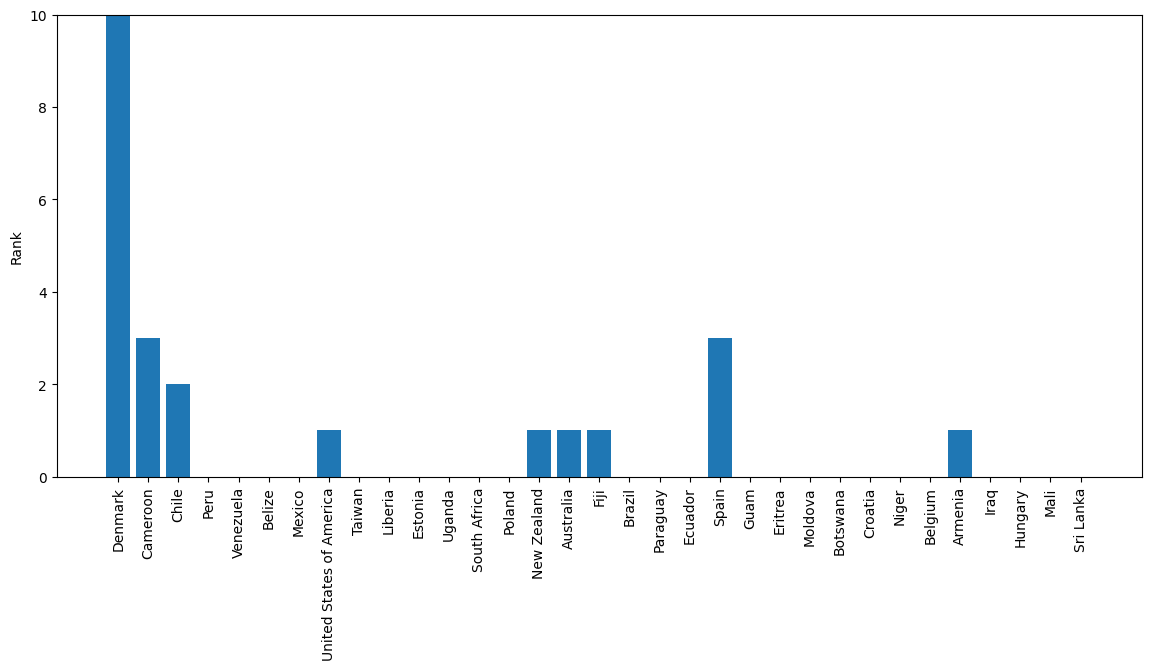

In [47]:
fig = plt.figure(figsize = (14, 6))
plt.bar(country_names, ranking)
plt.xticks(rotation=90)
plt.ylim((0, 10))
plt.ylabel("Rank")
plt.show()

### Log model

In [48]:
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.pytorch.log_model(model, "model")

Make sure to set promote your desired model to the Model Registry using the MLFlow UI. The model with the champion alias will be used by the ML server.  You can set the name of the model within the docker-compose.yml file or by setting the environment variable MODEL_NAME if you run the app locally.